In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nptdms import TdmsFile
import json
# Path to data
root_path = Path().cwd().parent
data_path = root_path / 'data' / 'processed'
# List of files
import sys
EPS = sys.float_info.epsilon

In [3]:
freq = np.load(data_path / 'freq.npy')
PSDs = np.load(data_path / 'PSDS.npy')
system_name = np.load(data_path / 'systems.npy')
states = np.load(data_path / 'states.npy')


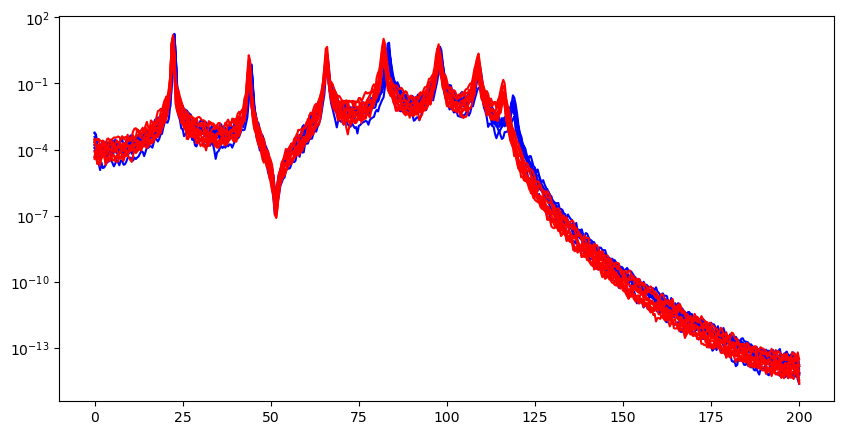

In [4]:
fig,ax= plt.subplots(figsize=(10,5))
counter_1 = 0
counter_2 = 0
for i in range(0,28000,1):
    if system_name[i] == 'system_0':
        if states[i]=='healthy' and counter_1 <10 :
            ax.semilogy(freq,PSDs[i],label='healthy',color='blue')
            counter_1 +=1
        elif states[i]=='anomalous' and counter_2 <10:
            ax.semilogy(freq,PSDs[i],label='anoumalous',color='red')
            counter_2 +=1


In [5]:
PSDs = np.log10(PSDs+EPS)


In [6]:
labels_name = {f'system_{i}' : i for i in range(0,20)}
def vec_translate(a, my_dict):    
    return np.vectorize(my_dict.__getitem__)(a)
system_name = vec_translate(system_name,labels_name)


In [7]:
print(f'amount of healthy samples {np.sum(states=="healthy")/len(states)} and amount of anomalous samples {np.sum(states=="anomalous")/len(states)}')


amount of healthy samples 0.8571428571428571 and amount of anomalous samples 0.14285714285714285


In [8]:
healthy_idx = np.where(states=='healthy')[0]
anomalous_idx = np.where(states=='anomalous')[0]

PSDs_healthy = PSDs[healthy_idx]
system_name_healthy = system_name[healthy_idx]

PSDs_anomalous = PSDs[anomalous_idx]
system_name_anomalous = system_name[anomalous_idx]


In [9]:
train_idx = np.random.choice(healthy_idx, size=20*500, replace=False)
test_idx = np.setdiff1d(healthy_idx, train_idx)

PSDs_healthy_train = PSDs_healthy[train_idx]
system_name_healthy_train = system_name_healthy[train_idx]

PSDs_healthy_test = PSDs_healthy[test_idx]
system_name_healthy_test = system_name_healthy[test_idx]



In [11]:
min_tr = PSDs_healthy_train.min()
max_tr = PSDs_healthy_train.max()
def normalize(data,min_value,max_value):
    return (data-min_value)/(max_value-min_value)



In [13]:
PSDs_healthy_train_nr = normalize(PSDs_healthy_train,min_tr,max_tr)
PSDs_healthy_test_nr = normalize(PSDs_healthy_test,min_tr,max_tr)
PSDs_anomalous_nr = normalize(PSDs_anomalous,min_tr,max_tr)

print(f'shapes :\n PSDs_healthy_train = {PSDs_healthy_train.shape} \n PSDs_healthy_test = {PSDs_healthy_test.shape} \n PSDs_anomalous = {PSDs_anomalous.shape}')

shapes :
 PSDs_healthy_train = (10000, 513) 
 PSDs_healthy_test = (14000, 513) 
 PSDs_anomalous = (4000, 513)


In [14]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(system_name_healthy_train.reshape(-1,1))
system_name_healthy_train = enc.transform(system_name_healthy_train.reshape(-1,1)).toarray()


In [43]:
from PBSHM_mdof.models.classification.dense_nn import DenseSignalClassifier

model_ = DenseSignalClassifier(inputDim=(PSDs_healthy_train.shape[-1],), num_class=20,dense_layers=[128,64,32])
model=model_.build_model()

In [44]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 513)]             0         
                                                                 
 dense_signal_classifier_3 (  (None, 20)               76788     
 DenseSignalClassifier)                                          
                                                                 
Total params: 76,788
Trainable params: 76,788
Non-trainable params: 0
_________________________________________________________________


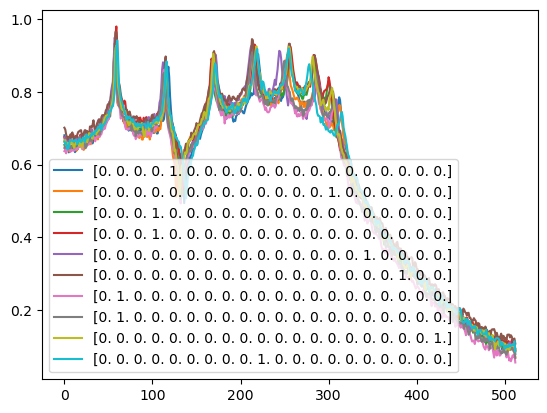

In [45]:
plt.plot(PSDs_healthy_train_nr[:10].T,label=system_name_healthy_train[:10])
plt.legend()

In [46]:
np.unique(np.argmax(system_name_healthy_train,axis=1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [47]:
model.fit(PSDs_healthy_train_nr, system_name_healthy_train, epochs=150, batch_size=128, validation_split=0.2)

Epoch 1/150
63/63 [==============================] - 2s 33ms/step - loss: 2.9928 - accuracy: 0.0540 - val_loss: 2.9697 - val_accuracy: 0.0840
Epoch 2/150
63/63 [==============================] - 1s 19ms/step - loss: 2.9065 - accuracy: 0.0868 - val_loss: 2.7717 - val_accuracy: 0.0900
Epoch 3/150
63/63 [==============================] - 1s 24ms/step - loss: 2.5793 - accuracy: 0.1510 - val_loss: 2.3686 - val_accuracy: 0.2015
Epoch 4/150
63/63 [==============================] - 1s 23ms/step - loss: 2.2515 - accuracy: 0.2362 - val_loss: 2.1063 - val_accuracy: 0.2995
Epoch 5/150
63/63 [==============================] - 1s 20ms/step - loss: 2.0550 - accuracy: 0.2951 - val_loss: 1.9772 - val_accuracy: 0.2625
Epoch 6/150
63/63 [==============================] - 2s 23ms/step - loss: 1.8779 - accuracy: 0.3641 - val_loss: 1.8110 - val_accuracy: 0.3235
Epoch 7/150
63/63 [==============================] - 1s 15ms/step - loss: 1.6887 - accuracy: 0.4369 - val_loss: 1.5666 - val_accuracy: 0.4820
Epoch 

In [48]:
prediction_healthy_test = model.predict(PSDs_healthy_test)

438/438 [==============================] - 4s 9ms/step


In [49]:
prediction_anomalous = model.predict(PSDs_anomalous)

125/125 [==============================] - 1s 10ms/step


In [50]:
index_system0_healthy = np.where(system_name_healthy_test==0)[0]


In [57]:
np.where(system_name_healthy_test==0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [53]:
np.argmax(prediction_healthy_test,axis=-1)

array([13, 13, 10, ..., 10, 10, 10])

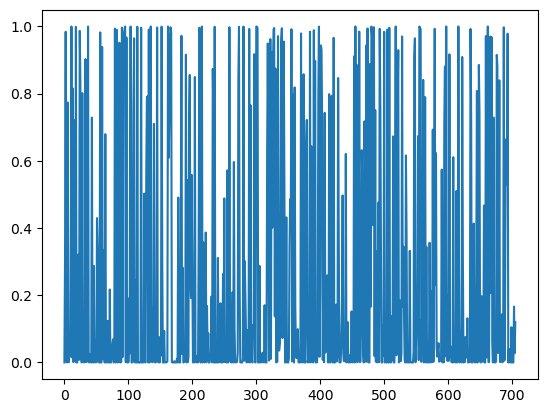

In [61]:
plt.plot(prediction_healthy_test[index_system0_healthy][:,10])

In [26]:
index_system_healthy = np.where(system_name_test==0)[0]

NameError: name 'system_name_test' is not defined

In [ ]:
index_system_anomalous = np.where(system_name_anomalous==0)[0]

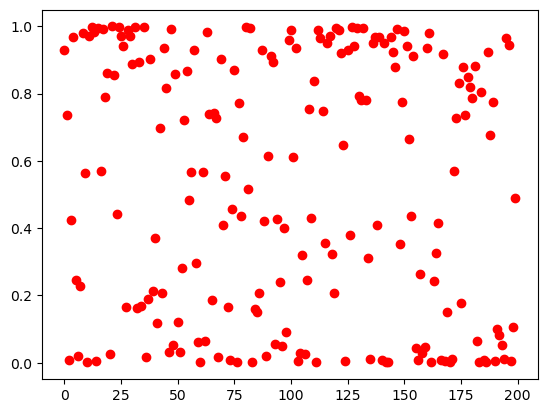

In [ ]:
plt.plot(prediction_anomalous[index_system_anomalous][:,0])

In [98]:
plt.plot(freq, PSDs_anomalous[index_system_anomalous].T)

NameError: name 'index_system_anomalous' is not defined

In [71]:
PSDs_0=normalize(PSDs[np.where(system_name==0)],min_tr,max_tr)
state_0 = states[np.where(system_name==0)]

In [74]:
predict_0=model.predict(PSDs_0)

44/44 [==============================] - 0s 9ms/step


In [118]:
predict_0

array([[9.9620700e-01, 1.0851688e-06, 3.3703030e-03, ..., 1.0841538e-12,
        2.0175468e-08, 2.3975591e-20],
       [9.8657066e-01, 9.6206830e-05, 7.8641676e-04, ..., 2.9563005e-09,
        2.6112223e-08, 1.3442288e-16],
       [9.9642557e-01, 1.1386370e-05, 1.1275738e-03, ..., 1.0613155e-10,
        1.4446504e-08, 4.3407692e-18],
       ...,
       [4.4258819e-03, 1.2278505e-12, 9.9068099e-01, ..., 2.1972870e-28,
        1.4974207e-04, 0.0000000e+00],
       [2.9478064e-03, 9.7428023e-13, 9.9570292e-01, ..., 8.0180604e-29,
        1.1478123e-04, 0.0000000e+00],
       [2.9484136e-03, 1.3518546e-12, 9.9656928e-01, ..., 3.3590943e-28,
        5.9881888e-05, 0.0000000e+00]], dtype=float32)

In [84]:
df_plot=pd.DataFrame({'confidence' : predict_0[:,0],
              'state' : state_0 })

<AxesSubplot: xlabel='confidence', ylabel='state'>

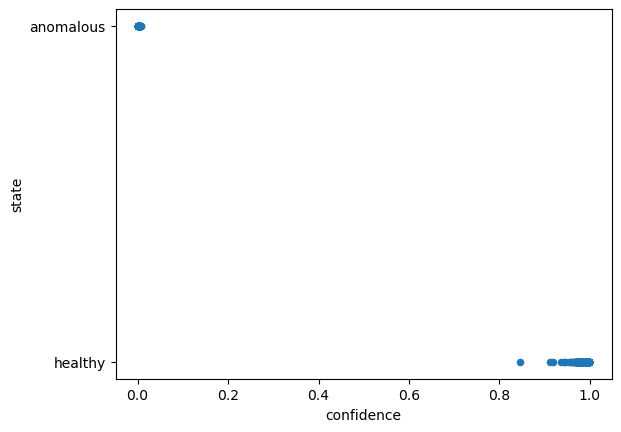

In [91]:
df_plot.plot(x='confidence',y='state',kind='scatter')


array([<AxesSubplot: title={'center': 'anomalous'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': 'healthy'}, ylabel='Frequency'>],
      dtype=object)

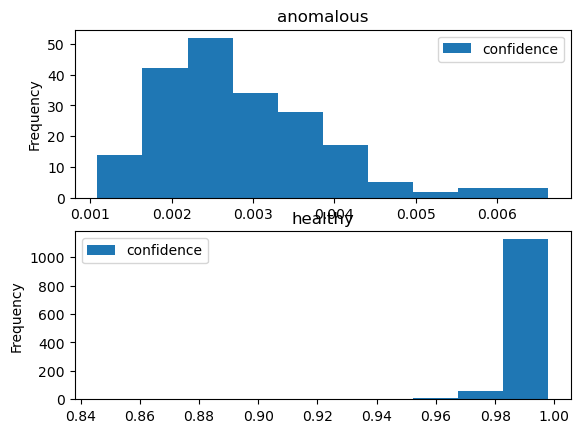

In [96]:
df_plot.plot.hist(by='state')


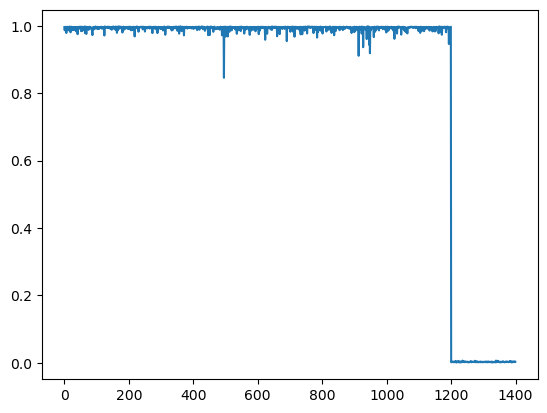

In [97]:
plt.plot(predict_0[:,0])

In [103]:
np.argmax(predict_0[1199:],axis=-1)

array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2])

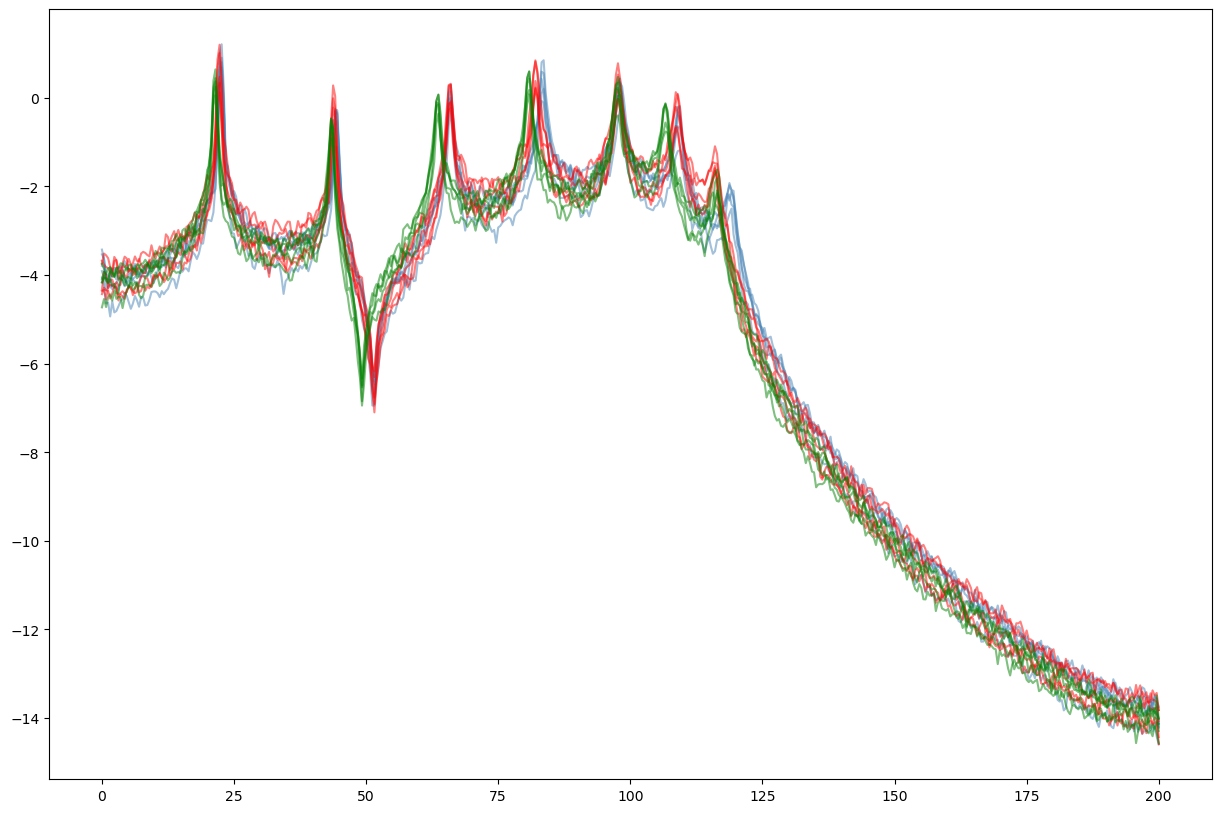

In [117]:
plt.figure(figsize=(15,10))
plt.plot(freq,PSDs[np.where((system_name==0) & (states=='healthy'))][0:5].T,color='steelblue',alpha=0.5)
plt.plot(freq,PSDs[np.where((system_name==0) & (states=='anomalous'))][0:5].T,color='red',alpha=0.5)
plt.plot(freq,PSDs[np.where((system_name==2) & (states=='anomalous'))][0:5].T,color='green',alpha=0.5)

In [ ]:
plt.plot(freq,PSDs[np.where(system_name==2)][0:10].T)